## Libraries and Tools

We import standard Python libraries and scikit‑learn modules that support data handling, visualization, feature extraction, modeling, and evaluation. A brief summary:

| Library | Role |
| --- | --- |
| pandas | Load and manipulate tabular data |
| numpy | Numerical operations |
| matplotlib.pyplot | Create charts (bar plots, histograms, curves) |
| wordcloud | Generate word clouds |
| scikit‑learn modules | Provide TF‑IDF vectorizer, classifiers (MultinomialNB, LogisticRegression), pipelines, model selection utilities, and metrics |


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

## Loading and Cleaning Data

We read the dataset from a CSV file and select the relevant columns:

- **news**: the full article text, renamed to `text` for clarity.
- **type**: the target category, renamed to `label`.

Rows with missing values are dropped, and the index is reset. After this step, the dataframe `df` contains the processed dataset ready for analysis.


In [ ]:

# Load the dataset
df = pd.read_csv("/content/dataset.csv", encoding='latin1')
df = df[['news', 'type']].dropna().reset_index(drop=True)
df.rename(columns={'news': 'text', 'type': 'label'}, inplace=True)

## Dataset Overview

To understand the dataset structure, we print its shape and view the first few rows.

- **Dataset shape**: shows the number of articles and columns.
- **Head preview**: lists the first entries, giving a sense of the text content and labels.


In [ ]:
# Display basic dataset info
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2225, 2)


,text,label
0,China had role in Yukos split-up\n \n China le...,business
1,Oil rebounds from weather effect\n \n Oil pric...,business
2,Indonesia 'declines debt freeze'\n \n Indonesi...,business
3,$1m payoff for former Shell boss\n \n Shell is...,business
4,US bank in $515m SEC settlement\n \n Five Bank...,business


## Exploratory Data Analysis – Class Distribution

We examine how many samples belong to each category to check if the dataset is balanced. A bar chart visualizes the distribution of the target labels across the five classes.


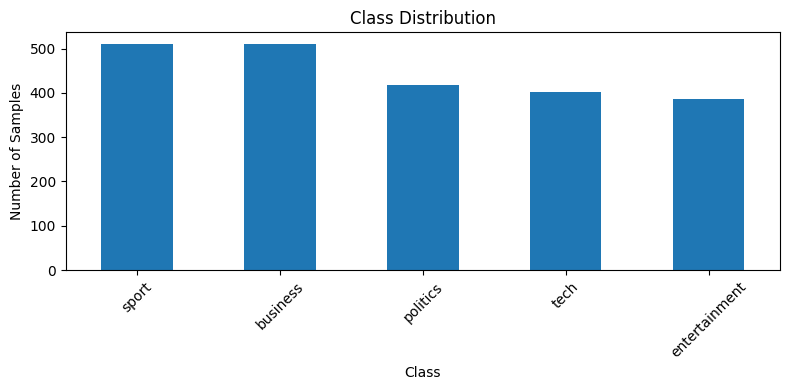

In [ ]:
## Exploratory Data Analysis

## We explore class distributions, text length distributions, and create word clouds to visualise common words both overall and per class.
# Class Distribution Plot
class_counts = df['label'].value_counts()

plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Exploratory Data Analysis – Text Length

We compute the number of words in each article (`text_length`) to assess article length variability. A histogram displays the distribution of word counts, highlighting typical article lengths and outliers.


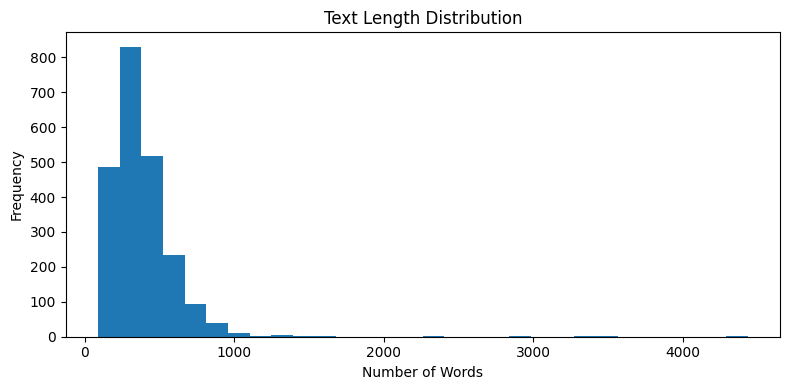

In [ ]:
#  Text Length Distribution
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
plt.hist(df['text_length'], bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Exploratory Data Analysis – Word Cloud

To visualize common words across the entire corpus, we join all articles into one large string and generate a word cloud. Words that appear frequently are displayed more prominently, giving an intuitive overview of the vocabulary.


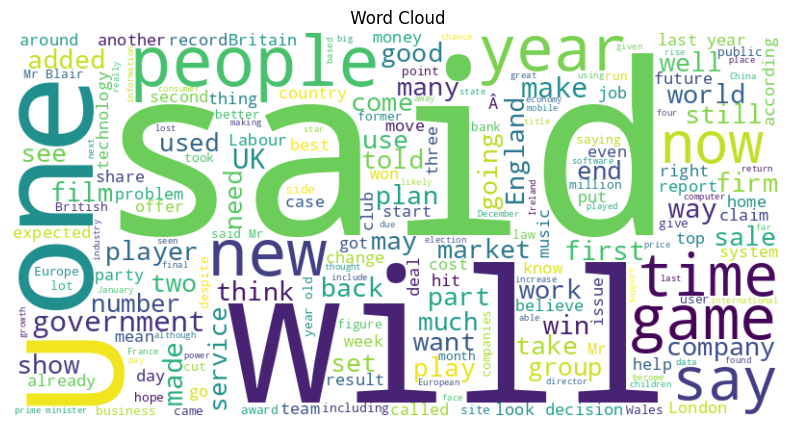

In [ ]:
### Word Cloud

# The overall word cloud highlights the most frequent words across the entire corpus.
# Cell: Word Cloud Overall
all_text = " ".join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' Word Cloud')
plt.show()

## Top TF‑IDF Features

TF‑IDF captures how important a word is to a document relative to the corpus. Here we:

- Fit a TF‑IDF vectorizer (unigrams, stop words removed).
- Compute the mean TF‑IDF score for each term across all documents.
- Identify and plot the 20 words with the highest average scores.

This bar chart highlights which terms are most informative for distinguishing between categories.


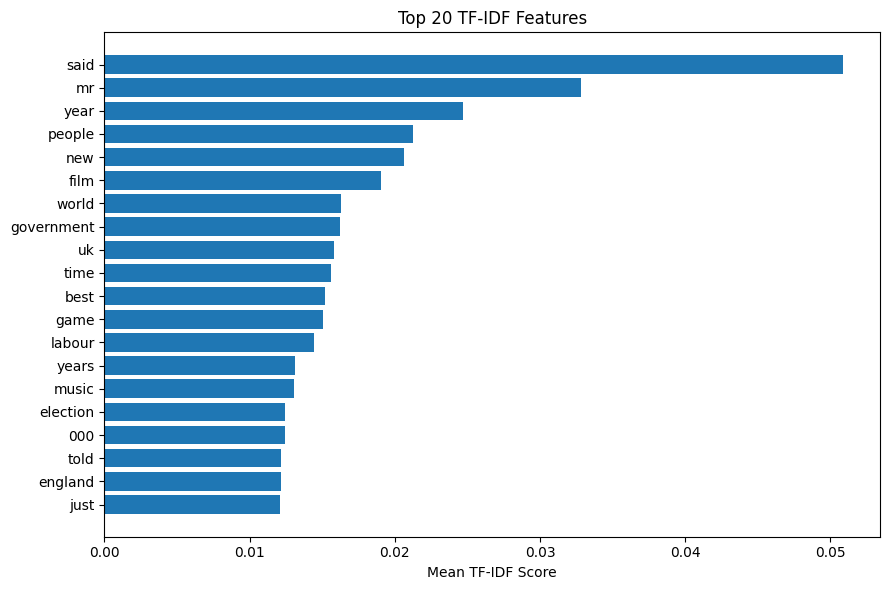

In [ ]:
## Top TF‑IDF Features

# We compute the top 20 TF‑IDF terms overall and per class. This provides insight into which words the TF‑IDF weighting considers most important.
#  Top TF‑IDF Features Overall
tfidf_explore = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 1))
X_tfidf = tfidf_explore.fit_transform(df['text'])
feature_names = np.array(tfidf_explore.get_feature_names_out())

mean_scores = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_idx = np.argsort(mean_scores)[::-1][:20]

plt.figure(figsize=(9, 6))
plt.barh(feature_names[top_idx][::-1], mean_scores[top_idx][::-1])
plt.title('Top 20 TF-IDF Features')
plt.xlabel('Mean TF-IDF Score')
plt.tight_layout()
plt.show()

## Train–Test Split

To evaluate our models on unseen data, we split the dataset into training and test sets:

- **80 % for training**, **20 % for testing**.
- Stratification ensures each category is proportionally represented.
- We set `random_state=42` for reproducibility.

The output confirms the number of samples in each set and lists the unique class labels.


In [ ]:
#Train/Test Split
#We use an 80/20 split with stratification to preserve class proportions and random_state=42 for reproducibility.

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

classes = np.unique(y_train)
print('Train size:', len(X_train_text), 'Test size:', len(X_test_text))
print('Classes:', classes)


Train size: 1780 Test size: 445
Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']


## Model Building – Pipelines

Two classical text classifiers are configured using scikit‑learn pipelines:

- **Multinomial Naïve Bayes**: suitable for word count features.
- **Logistic Regression**: a linear classifier with regularization (here using a high `max_iter` to ensure convergence).

Each pipeline pairs a TF‑IDF vectorizer with the classifier. Defining models within pipelines prevents data leakage and guarantees consistent preprocessing for both models.


In [ ]:

#Models (TF‑IDF + Classifier Pipelines)
#Two classical text classification models are trained and compared:

#Multinomial Naïve Bayes
#Logistic Regression
#Using Pipeline prevents leakage and ensures identical feature extraction settings for both models.

nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 1))),
    ('clf', MultinomialNB())
])

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 1))),
    ('clf', LogisticRegression(max_iter=2000))
])

models = {
    'Naive Bayes (TF-IDF)': nb_pipe,
    'Logistic Regression (TF-IDF)': lr_pipe
}

## Evaluation Helpers

We define a helper function `plot_confusion` that draws a confusion matrix with color coding and annotations. It takes:

- `cm`: the confusion matrix.
- `labels`: class names.
- `title`: plot title.

The function customizes tick labels and text colors to improve readability. This utility simplifies confusion matrix visualization for different models.


In [ ]:
# Evaluation Helpers
# We compute accuracy, weighted precision/recall/F1, classification report, and confusion matrix.

def plot_confusion(cm, labels, title):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=30, ha='right')
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha='center', va='center',
                     color='white' if val > thresh else 'black')

    plt.tight_layout()
    plt.show()


def eval_model(name, model, X_test, y_test, classes):
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)

    cm = confusion_matrix(y_test, preds, labels=classes)

    print("\n {} ".format(name))
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f} (weighted)")
    print(f"Recall:    {rec:.4f} (weighted)")
    print(f"F1-score:  {f1:.4f} (weighted)")
    print("\nClassification Report:\n", classification_report(y_test, preds, zero_division=0))

    plot_confusion(cm, labels=classes, title=f"Confusion Matrix - {name}")

    row = {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    return preds, row


## Confusion Matrices

We compute and display confusion matrices for both classifiers:

- **Naïve Bayes**: plotted in shades of green.
- **Logistic Regression**: plotted in shades of blue.
- We also show a combined matrix (element‑wise sum) to compare misclassifications across models.

These matrices reveal which categories are most often confused and highlight strengths and weaknesses of each model.


<Figure size 600x500 with 0 Axes>

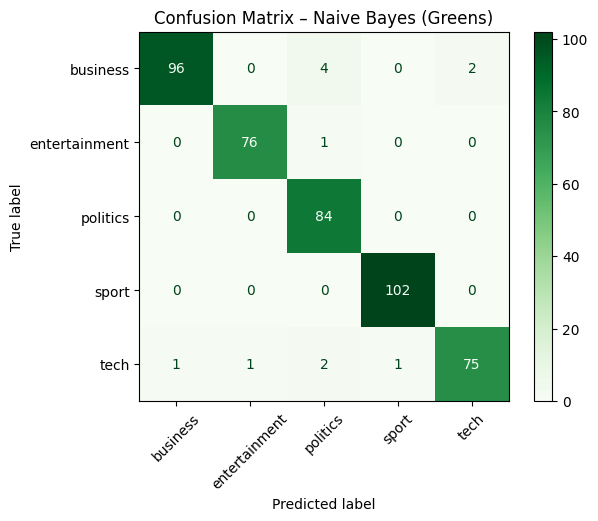

<Figure size 600x500 with 0 Axes>

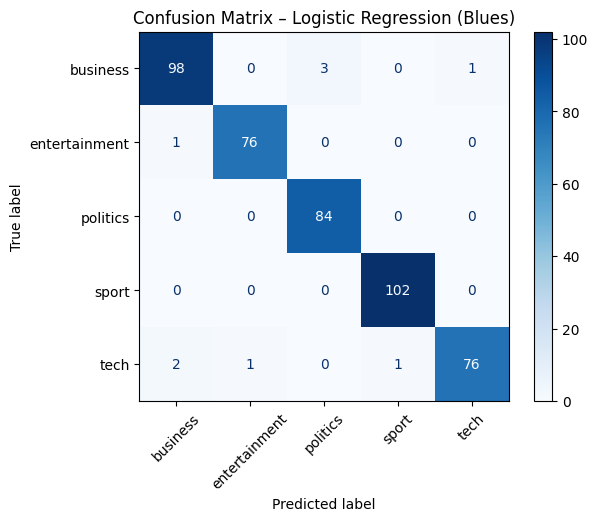

<Figure size 600x500 with 0 Axes>

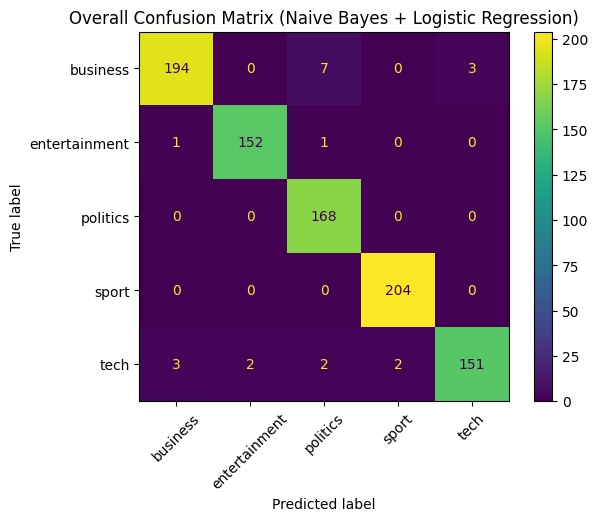

In [ ]:
#  Confusion Matrix – Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=unique_labels)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=unique_labels)
plt.figure(figsize=(6, 5))
disp_nb.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix – Naive Bayes (Greens)')
plt.show()

#  Confusion Matrix – Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=unique_labels)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=unique_labels)
plt.figure(figsize=(6, 5))
disp_lr.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix – Logistic Regression (Blues)')
plt.show()

#  Overall Confusion Matrix (sum of both models)
cm_overall = cm_nb + cm_lr
disp_overall = ConfusionMatrixDisplay(confusion_matrix=cm_overall, display_labels=unique_labels)
plt.figure(figsize=(6, 5))
disp_overall.plot(xticks_rotation=45)
plt.title('Overall Confusion Matrix (Naive Bayes + Logistic Regression)')
plt.show()


## Normalized Confusion Matrices

A wrapper function `plot_cm` plots both raw and normalized confusion matrices for each model. Normalization divides each row by its sum, showing the proportion of correct and incorrect predictions per class. Comparing normalized matrices provides insight into relative performance across categories.


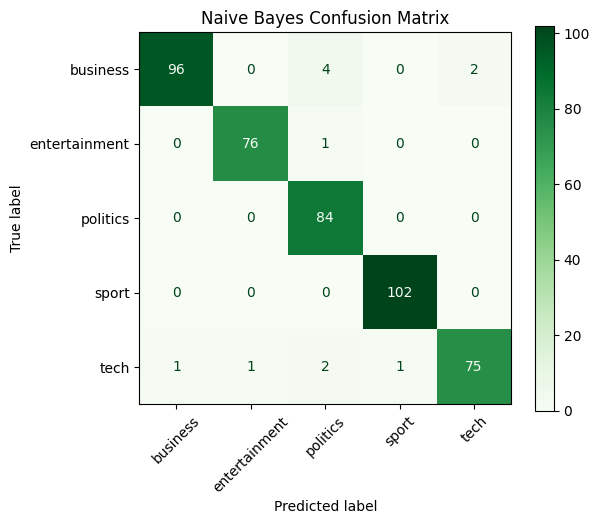

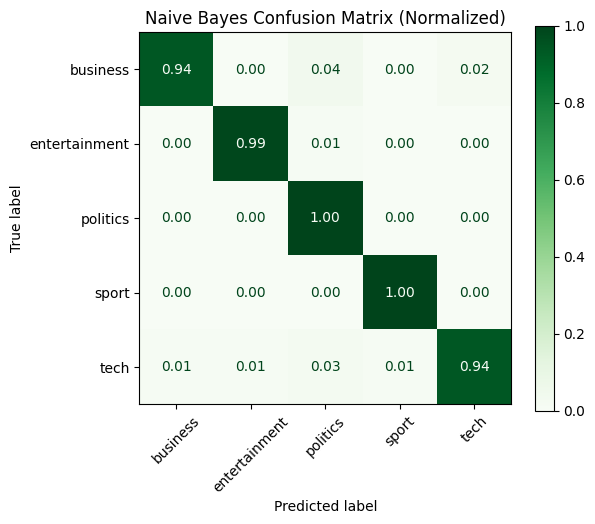

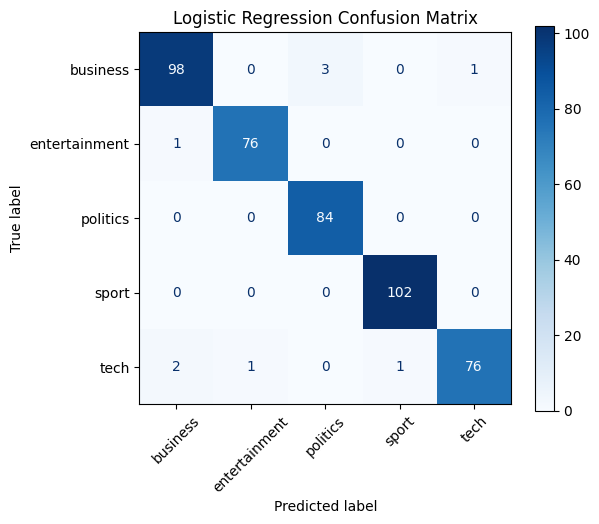

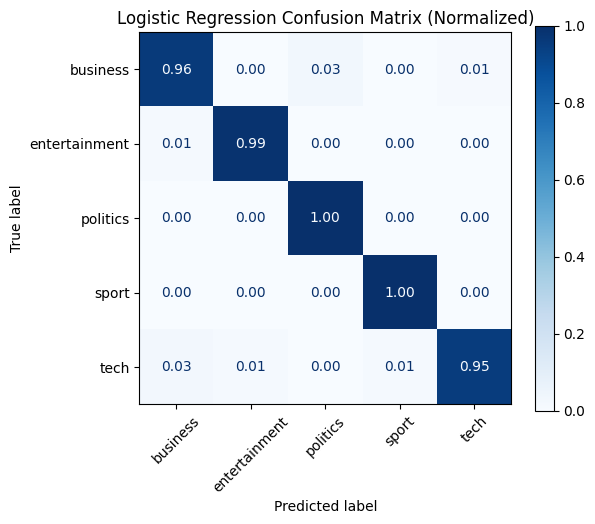

In [ ]:

classes = np.unique(y_test)

def plot_cm(y_true, y_pred, title, cmap, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap=cmap, xticks_rotation=45, values_format=".2f" if normalize else "d")
    ax.set_title(title + (" (Normalized)" if normalize else ""))
    plt.show()

# NB
plot_cm(y_test, y_pred_nb, "Naive Bayes Confusion Matrix", "Greens", normalize=False)
plot_cm(y_test, y_pred_nb, "Naive Bayes Confusion Matrix", "Greens", normalize=True)

# LR
plot_cm(y_test, y_pred_lr, "Logistic Regression Confusion Matrix", "Blues", normalize=False)
plot_cm(y_test, y_pred_lr, "Logistic Regression Confusion Matrix", "Blues", normalize=True)


## ROC and Precision–Recall Curves

Because the task is multiclass, we binarize the labels and compute micro‑averaged curves:

- `y_test_bin`: one‑hot encoding of true labels.
- `y_score_nb` and `y_score_lr`: predicted probabilities from Naïve Bayes and Logistic Regression, respectively.

We then:

- Plot ROC curves (true positive rate vs. false positive rate) and calculate the area under the curve (AUC) for each model.
- Plot Precision–Recall curves (precision vs. recall) and compute the average precision.

These plots allow direct visual comparison of classifier performance across thresholds.


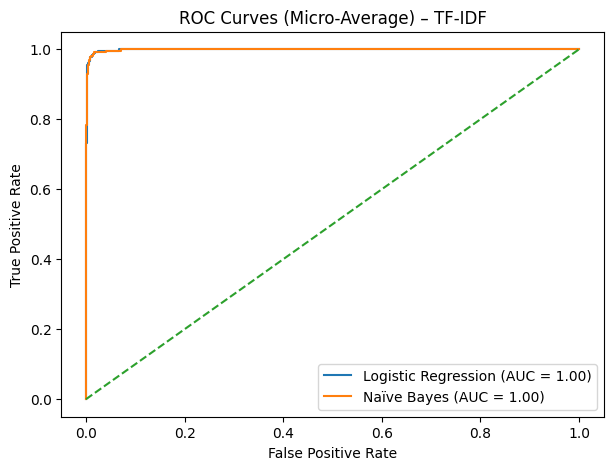

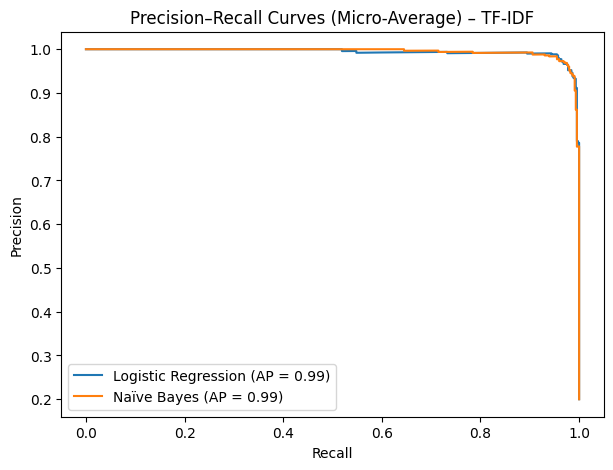

In [ ]:
### ROC and Precision–Recall Curves

## We compute micro‑average ROC and Precision–Recall curves for both models and plot them together for comparison.  Labels are binarized to handle multiclass ROC.

# Cell: Binarize labels for ROC/PR curves
classes = unique_labels
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score_lr = lr_model.predict_proba(X_test_tfidf)
y_score_nb = nb_model.predict_proba(X_test_tfidf)

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test_bin.ravel(), y_score_lr.ravel())
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_nb, tpr_nb, _ = roc_curve(y_test_bin.ravel(), y_score_nb.ravel())
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naïve Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Micro‑Average) – TF-IDF")
plt.legend()
plt.show()

# Precision–Recall curves
prec_lr, rec_lr, _ = precision_recall_curve(y_test_bin.ravel(), y_score_lr.ravel())
ap_lr = average_precision_score(y_test_bin, y_score_lr, average='micro')

prec_nb, rec_nb, _ = precision_recall_curve(y_test_bin.ravel(), y_score_nb.ravel())
ap_nb = average_precision_score(y_test_bin, y_score_nb, average='micro')

plt.figure(figsize=(7, 5))
plt.plot(rec_lr, prec_lr, label=f"Logistic Regression (AP = {ap_lr:.2f})")
plt.plot(rec_nb, prec_nb, label=f"Naïve Bayes (AP = {ap_nb:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Micro‑Average) – TF-IDF")
plt.legend()
plt.show()


## Performance Summary

We compile key metrics for both models into a summary:

- **Accuracy**
- **Macro‑averaged Precision**
- **Macro‑averaged Recall**
- **Macro‑averaged F1 score**

A bar chart emphasises small differences between models. This table and chart help decide which model provides better overall performance.


,Model,Accuracy,Precision (macro),Recall (macro),F1-Score (macro)
0,Naive Bayes,0.973034,0.972820,0.973138,0.972475
1,Logistic Regression,0.979775,0.980026,0.979559,0.979652


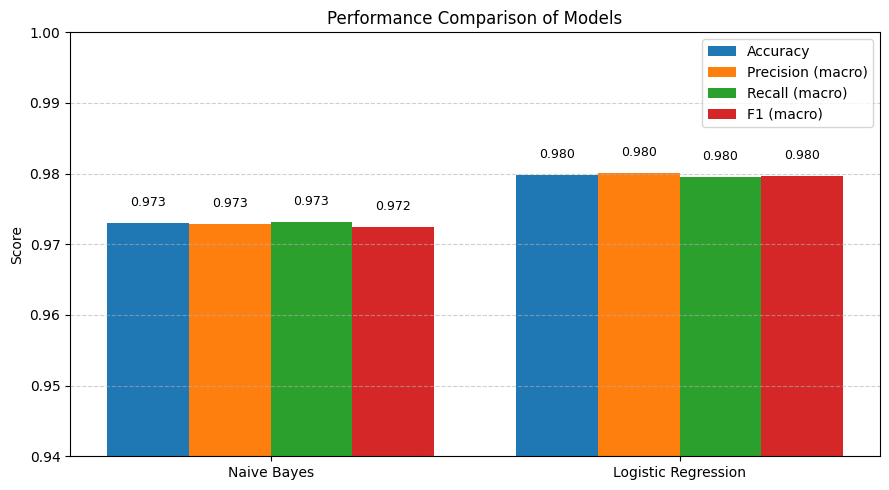

In [ ]:
### Performance Comparison

# We summarise accuracy, precision, recall, and F1 scores for each model
# and visualise them with an improved bar chart that highlights small differences.

# Metric Summary Table

metrics_data = {
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision (macro)': [
        precision_score(y_test, y_pred_nb, average='macro'),
        precision_score(y_test, y_pred_lr, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_nb, average='macro'),
        recall_score(y_test, y_pred_lr, average='macro')
    ],
    'F1-Score (macro)': [
        f1_score(y_test, y_pred_nb, average='macro'),
        f1_score(y_test, y_pred_lr, average='macro')
    ]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)


# Improved Bar Chart

fig, ax = plt.subplots(figsize=(9, 5))

index = np.arange(len(metrics_df))
bar_width = 0.2

bars_acc = ax.bar(
    index - bar_width * 1.5,
    metrics_df['Accuracy'],
    bar_width,
    label='Accuracy'
)

bars_prec = ax.bar(
    index - bar_width * 0.5,
    metrics_df['Precision (macro)'],
    bar_width,
    label='Precision (macro)'
)

bars_rec = ax.bar(
    index + bar_width * 0.5,
    metrics_df['Recall (macro)'],
    bar_width,
    label='Recall (macro)'
)

bars_f1 = ax.bar(
    index + bar_width * 1.5,
    metrics_df['F1-Score (macro)'],
    bar_width,
    label='F1 (macro)'
)

# X-axis settings
ax.set_xticks(index)
ax.set_xticklabels(metrics_df['Model'])


ax.set_ylim(0.94, 1.00)

ax.set_title('Performance Comparison of Models')
ax.set_ylabel('Score')
ax.legend()

# Grid for readability
ax.grid(axis='y', linestyle='--', alpha=0.6)


# Add Value Labels on Bars

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

add_value_labels(bars_acc)
add_value_labels(bars_prec)
add_value_labels(bars_rec)
add_value_labels(bars_f1)

plt.tight_layout()
plt.show()


## Cross‑Validation

To assess model stability, we perform 5‑fold cross‑validation:

- We compute the cross‑validation accuracy scores (`cv_lr`, `cv_nb`) on the TF‑IDF transformed training data.
- We print the mean accuracy for each model.
- A boxplot visualizes the distribution of accuracy across folds for both classifiers.

Cross‑validation helps evaluate how well the models generalize beyond the specific train–test split.


Logistic Regression CV mean: 0.9735955056179776
Naive Bayes CV mean: 0.9713483146067416


/tmp/ipython-input-3392066569.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_nb, cv_lr], labels=['Naive Bayes', 'Logistic Regression'])


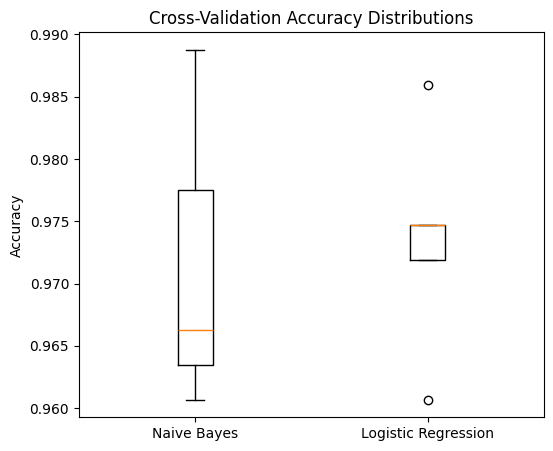

In [ ]:
### Cross‑Validation

##We compute 5‑fold cross‑validation scores for each model to examine their stability and show a boxplot of the fold accuracies.

# Cross-Validation Scores
cv_lr = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5)
cv_nb = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5)

print("Logistic Regression CV mean:", cv_lr.mean())
print("Naive Bayes CV mean:", cv_nb.mean())

# Cross-Validation Boxplot
plt.figure(figsize=(6, 5))
plt.boxplot([cv_nb, cv_lr], labels=['Naive Bayes', 'Logistic Regression'])
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Distributions')
plt.show()

## Cross‑Validation with Pipelines

When cross‑validating text models, the TF‑IDF transformation must be refitted within each fold to avoid data leakage. We define new pipelines (`pipe_nb`, `pipe_lr`) and perform 5‑fold cross‑validation on the raw text:

- This ensures that the vectorizer learns only from training data in each fold.
- We report the mean and standard deviation of accuracy for both models.

These results provide a fairer estimate of true generalization performance.


In [ ]:
# Proper pipelines (TF-IDF fitted inside each fold)
pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", MultinomialNB())
])

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])

# 5-fold cross-validation on RAW text
cv_nb = cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring="accuracy")
cv_lr = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring="accuracy")

print("Naive Bayes CV Accuracy (mean ± std):",
      f"{cv_nb.mean():.4f} ± {cv_nb.std():.4f}")

print("Logistic Regression CV Accuracy (mean ± std):",
      f"{cv_lr.mean():.4f} ± {cv_lr.std():.4f}")

Naive Bayes CV Accuracy (mean ± std): 0.9708 ± 0.0124
Logistic Regression CV Accuracy (mean ± std): 0.9730 ± 0.0081


## Learning Curves

Learning curves show how model performance evolves as we increase the training set size:

- We compute training and cross‑validation accuracies for Naïve Bayes and Logistic Regression at various proportions of the training data.
- Plots illustrate whether the models are underfitting (high bias) or overfitting (high variance).

Observing the gap between training and validation curves helps determine if more data or different model complexity would improve performance.


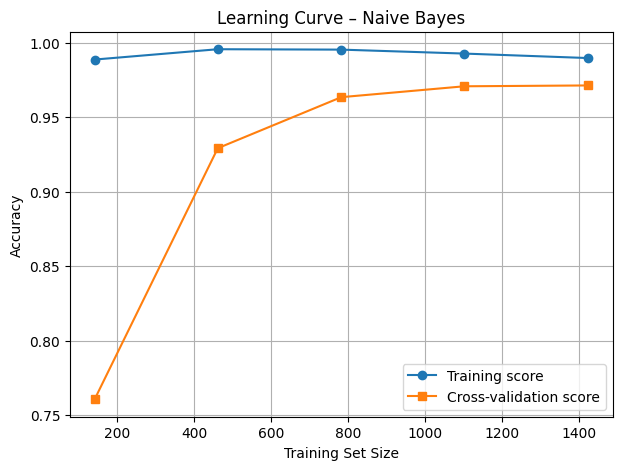

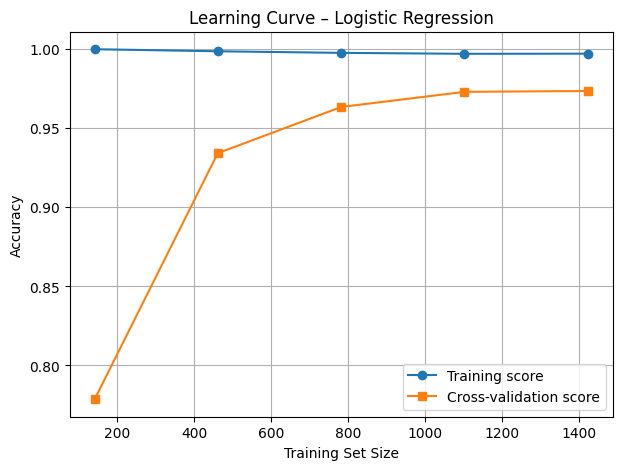

In [ ]:
### Learning Curves

##Learning curves show how training and validation scores evolve as the training set size increases.  We plot separate learning curves for both models.

# Learning Curve – Naive Bayes
train_sizes_nb, train_scores_nb, test_scores_nb = learning_curve(
    nb_model, X_train_tfidf, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_nb_mean = train_scores_nb.mean(axis=1)
test_scores_nb_mean = test_scores_nb.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes_nb, train_scores_nb_mean, marker='o', label='Training score')
plt.plot(train_sizes_nb, test_scores_nb_mean, marker='s', label='Cross-validation score')
plt.title('Learning Curve – Naive Bayes')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Learning Curve – Logistic Regression
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(
    lr_model, X_train_tfidf, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_lr_mean = train_scores_lr.mean(axis=1)
test_scores_lr_mean = test_scores_lr.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes_lr, train_scores_lr_mean, marker='o', label='Training score')
plt.plot(train_sizes_lr, test_scores_lr_mean, marker='s', label='Cross-validation score')
plt.title('Learning Curve – Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Misclassification Examples

To understand typical errors, we extract the test samples where the logistic regression predictions differ from the true labels. A table displays a subset of misclassified texts along with their true and predicted categories. This qualitative inspection can reveal ambiguous or noisy articles and highlight potential areas for improvement.


In [ ]:
### Misclassification Examples

##We list some instances where the model predictions differ from the true labels, giving insight into common error patterns.

#  Misclassification Table
misclassified_indices = np.where(y_test != y_pred_lr)[0]
misclassified_df = pd.DataFrame({
    'Text': X_test_text[misclassified_indices],
    'True Label': y_test[misclassified_indices],
    'Predicted Label (LR)': y_pred_lr[misclassified_indices]
})

display(misclassified_df.head(10))

,Text,True Label,Predicted Label (LR)
0,Call to save manufacturing jobs\n \n The Trade...,business,politics
1,Golden rule 'intact' says ex-aide\n \n Chancel...,business,politics
2,China 'ripe' for media explosion\n \n Asia is ...,tech,business
3,Ban on forced retirement under 65\n \n Employe...,business,politics
4,Man auctions ad space on forehead\n \n A 20-ye...,tech,business
5,Card fraudsters 'targeting web'\n \n New safeg...,business,tech
6,Football Manager scores big time\n \n For the ...,tech,sport
7,No charges against TV's Cosby\n \n US comedian...,entertainment,business
8,BBC leads interactive Bafta wins\n \n The BBC ...,tech,entertainment


## Model Demonstration

We select a single example from the test set to demonstrate the classifier in action. The cell prints:

- The article text.
- The true label.
- The predicted label produced by the logistic regression model.

This example illustrates how the model outputs a label for unseen text.


In [ ]:
### Model in Action

##Below is a demonstration of the model on a single example from the test set, showing the input text, true label, and predicted label.

# Sample Prediction Display
sample_index = 0
sample_text = X_test_text[sample_index]
sample_true = y_test[sample_index]
sample_pred = lr_model.predict(X_test_tfidf[sample_index])

print("Sample Text:\n", sample_text)
print("\nTrue Label:", sample_true)
print("Predicted Label (Logistic Regression):", sample_pred[0])

Sample Text:
 Yukos seeks court action on sale
 
 Yukos will return to a US court on Wednesday to seek sanctions against Baikal Finance Group, the little-known firm which has bought its main asset.
 
 Yukos has said it will sue Baikal and others involved in the sale of Yuganskneftegas for $20bn in damages. Yukos' US lawyers will attempt to have Baikal assets frozen after the Russian government ignored a US court order last week blocking the sale. Baikal's background and its motives for buying the unit are still unclear.
 
 Russian newspapers have claimed that Baikal - which bought the Yuganskneftegas production unit for $9.4bn (261bn roubles, Â£4.8bn) on Sunday at a state provoked auction - has strong links with Surgutneftegas, Russia's fourth-biggest oil producer. Many observers believe that the unit, which produces 60% of Yukos' oil output, could ultimately fall into the hands of Surgutneftegas or even Gazprom, the state gas firm which opted out of the auction.
 
 The Russian governm